In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=False)

# the directory where your data is
PATH_to_data = '/content/drive/My Drive/STROKE_code/MMPOSE/data/patient_output/processed/NIHSS/'
import os
os.chdir(PATH_to_data)
import sys
sys.path.append(PATH_to_data)

import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess = tf.compat.v1.Session(config=config)
tf.compat.v1.keras.backend.set_session(sess)

import numpy as np
import pandas as pd

Mounted at /content/drive
Num GPUs Available:  1


In [ ]:
# Load the data of 3 classes
'''
X_test3  = pd.read_csv('X_test3.csv')
X_train3 = pd.read_csv('X_train3.csv')
Y_test3  = pd.read_csv('Y_test3.csv')
Y_train3 = pd.read_csv('Y_train3.csv')

X_test3.head()
Y_train3['Weakness side'].unique()
'''

"\nX_test3  = pd.read_csv('X_test3.csv')\nX_train3 = pd.read_csv('X_train3.csv')\nY_test3  = pd.read_csv('Y_test3.csv')\nY_train3 = pd.read_csv('Y_train3.csv')\n\nX_test3.head()\nY_train3['Weakness side'].unique()\n"

In [ ]:
# Load the data of 2 classes (for each hand 1: if NIHSS<2, 2: if NIHSS>=2) 0-1 vs 2-4
X_test2  = pd.read_csv('X_test2.csv')
X_train2 = pd.read_csv('X_train2.csv')
Y_test2  = pd.read_csv('Y_test2.csv')
Y_train2 = pd.read_csv('Y_train2.csv')

In [ ]:
Y_train2.head()

,NIHSS,L Motor Arm Score,R Motor Arm Score,L Motor Leg Score,R Motor Leg Score,left-2,right-2,left-opposite-2,right-opposite-2,chunk
0,6.0,4.0,0.0,2.0,0.0,1,0,2,0,2
1,6.0,4.0,0.0,2.0,0.0,1,0,2,0,2
2,6.0,4.0,0.0,2.0,0.0,1,0,2,0,2
3,6.0,4.0,0.0,2.0,0.0,1,0,2,0,2
4,6.0,4.0,0.0,2.0,0.0,1,0,2,0,2


In [ ]:
#Y_train2 = Y_train2.loc[:, Y_train2.columns.isin(['L Motor Arm Score', 'patient_number', 'patient_code', 'Weakness on presentation',  'seconds', 'time_diff','Z1','Z2','Z3','Z4','Z5','Z6','Z7','Z8','Z9','Z10'])]
Y_train2 = Y_train2.loc[ :, Y_train2.columns.isin( ['left-2'] ) ]
Y_test2  = Y_test2.loc [ :, Y_test2.columns.isin( ['left-2'] ) ]
Y_train2.head()

,left-2
0,1
1,1
2,1
3,1
4,1


In [ ]:
X_train2.shape

(870000, 25)

In [ ]:
# comment if dont need shoulders
'''
X_test2 = X_test2.drop(['l_shoulder', 'r_shoulder'], axis=1)
X_train2 = X_train2.drop(['l_shoulder', 'r_shoulder'], axis=1)

X_test3 = X_test3.drop(['l_shoulder', 'r_shoulder'], axis=1)
X_train3 = X_train3.drop(['l_shoulder', 'r_shoulder'], axis=1)
'''

"\nX_test2 = X_test2.drop(['l_shoulder', 'r_shoulder'], axis=1)\nX_train2 = X_train2.drop(['l_shoulder', 'r_shoulder'], axis=1)\n\nX_test3 = X_test3.drop(['l_shoulder', 'r_shoulder'], axis=1)\nX_train3 = X_train3.drop(['l_shoulder', 'r_shoulder'], axis=1)\n"

In [ ]:
print(Y_train2.shape)
print(Y_test2.shape)

(870000, 1)
(372000, 1)


In [ ]:
'''
print(Y_train3.shape)
print(Y_test3.shape)
'''

'\nprint(Y_train3.shape)\nprint(Y_test3.shape)\n'

In [ ]:
#import tensorflow.keras as keras
from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split
from os import listdir
from os.path import isfile, join, dirname, abspath

# the length of records (if shorter, we need to add some zero rows)
NUMBER_TIMESTEPS = 1000
# the number of features (from the data)
NUMBER_FEATURES = 24 # 22 or 24 if you add shoulders
# the number of classes/gestures
NUMBER_OUTPUTS_1 = 1
NUMBER_OUTPUTS_2 = 2
NUMBER_OUTPUTS_3 = 3

In [ ]:
#!pip install tensorflow-addons
#import tensorflow_addons as tfa
#, tfa.metrics.F1Score(num_classes=1, average=None)

In [ ]:
learn_rate=0.0002
decay_rate = 0.000005

def build_model(NUMBER_OUTPUTS, NUMBER_FEATURES):
    model = models.Sequential()
    # an input layer that expects:
    # 1 or more samples, NUMBER_TIMESTEPS time steps and NUMBER_FEATURES features.

    # 1st LSTM layer
    model.add(layers.LSTM(256, return_sequences=True, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    model.add(layers.Dropout(0.2))

    # 2nd LSTM layer
    model.add(layers.LSTM(256, input_shape=(NUMBER_TIMESTEPS, NUMBER_FEATURES)) )
    model.add(layers.Dropout(0.2))

    # Hidden fully connected layers of the neural network
    model.add(layers.Dense(512,activation='relu'))
    model.add(layers.Dropout(0.2))
    #model.add(layers.Dense(256,activation='relu'))
    #model.add(layers.Dropout(0.2)) #0.2 or 0.5
    #model.add(layers.Dense(512,activation='relu'))

    # Classification layer of the neural network
    model.add(layers.Dense(NUMBER_OUTPUTS, activation='sigmoid')) #softmax=multiple sigmoid=2

    opt = Adam(amsgrad=True, learning_rate=learn_rate)#, beta_1=0.9, beta_2=0.999)
    model.compile(loss='binary_crossentropy', optimizer=opt, metrics=['accuracy','Precision','Recall' ]) # categorical_crossentropy #,'accuracy', 'Precision','Recall'

    # this shows the network structure
    model.summary()

    return model

# Define the learning rate decay function
def lr_decay(epoch):
    return learn_rate * decay_rate * epoch



In [ ]:
# creating the model
model = build_model(NUMBER_OUTPUTS_1, NUMBER_FEATURES)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 1000, 256)         287744    
                                                                 
 dropout (Dropout)           (None, 1000, 256)         0         
                                                                 
 lstm_1 (LSTM)               (None, 256)               525312    
                                                                 
 dropout_1 (Dropout)         (None, 256)               0         
                                                                 
 dense (Dense)               (None, 512)               131584    
                                                                 
 dropout_2 (Dropout)         (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 1)                 5

In [ ]:
Y_train2['left-2'].value_counts(normalize=False)

0    473000
1    397000
Name: left-2, dtype: int64

In [ ]:
Y_train2['left-2'].value_counts(normalize=True)

0    0.543678
1    0.456322
Name: left-2, dtype: float64

In [ ]:
Y_test2['left-2'].value_counts(normalize=False)

0    193000
1    179000
Name: left-2, dtype: int64

In [ ]:
Y_test2['left-2'].value_counts(normalize=True)

0    0.518817
1    0.481183
Name: left-2, dtype: float64

In [ ]:
#Y_train3['Weakness side'].value_counts(normalize=False)

In [ ]:
X_train2.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder,chunk
0,911.78656,387.92413,849.28235,439.86950,1012.68500,415.36970,767.19170,407.26930,1143.6213,365.763670,...,540.30670,1106.2367,354.66296,918.57240,475.88315,0.667932,13.257076,146.933103,51.403952,2
1,677.66720,816.14667,677.66720,831.35880,692.87946,770.50995,692.87946,800.93440,784.1528,709.661100,...,846.57110,738.5162,816.14667,905.85065,572.75104,36.869900,52.125008,74.931530,101.309934,2
2,819.80000,249.58182,859.02496,389.20898,908.11865,234.20256,853.98830,373.97644,1089.4350,343.495240,...,516.15390,1052.9427,376.73240,833.44763,516.39550,22.450994,29.676850,125.554920,67.081064,2
3,630.49304,622.49176,521.73880,629.06990,536.48770,515.77594,607.96466,555.44037,717.9236,672.994400,...,527.83997,837.3358,678.73760,1103.76660,938.44543,40.840140,75.525930,18.996162,174.590821,2
4,1032.32710,181.25116,1015.08630,117.29236,1114.51780,96.71414,1079.35400,85.68940,1156.3785,102.440025,...,439.39056,1340.6447,613.65340,1244.96720,458.82202,119.939430,99.894630,105.334741,120.755944,2


In [ ]:
# 3 classes Y
'''
Y_train3['Weakness side'] = Y_train3['Weakness side'].replace({'L': 1, 'R': 2, 'none': 3})
Y_test3['Weakness side']   = Y_test3['Weakness side'].replace({'L': 1, 'R': 2, 'none': 3})
'''

"\nY_train3['Weakness side'] = Y_train3['Weakness side'].replace({'L': 1, 'R': 2, 'none': 3})\nY_test3['Weakness side']   = Y_test3['Weakness side'].replace({'L': 1, 'R': 2, 'none': 3})\n"

In [ ]:
# 2 classes Y

#Y_train2['left-2'] = Y_train2['left-2'].replace({1.0: 0, 2.0: 1})
#Y_test2['left-2']  = Y_test2['left-2'].replace({1.0: 0, 2.0: 1})

# one-hot encode the label column Y
'''
Y_train_encoded = pd.get_dummies(Y_train3['Weakness side'])
Y_test_encoded  = pd.get_dummies(Y_test3 ['Weakness side'])
'''

'''
Y_train_encoded2 = pd.get_dummies(Y_train2['Weakness side'])
Y_test_encoded2  = pd.get_dummies(Y_test2 ['Weakness side'])

Y_test_encoded2.head()
'''

"\nY_train_encoded2 = pd.get_dummies(Y_train2['Weakness side'])\nY_test_encoded2  = pd.get_dummies(Y_test2 ['Weakness side'])\n\nY_test_encoded2.head()\n"

In [ ]:
Y_test2['left-2'].unique()

array([1, 0])

In [ ]:
X_train2 = X_train2.drop(columns=['chunk'])
X_test2  = X_test2.drop(columns=['chunk'])

In [ ]:
X_train2.head()
#X_train2[ ['X5','X6','X7','X8','X9','X10','Y5','Y6','Y7','Y8','Y9','Y10','r_degr','l_degr'] ].head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,...,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder
0,911.78656,387.92413,849.28235,439.86950,1012.68500,415.36970,767.19170,407.26930,1143.6213,365.763670,...,1113.31690,540.30670,1106.2367,354.66296,918.57240,475.88315,0.667932,13.257076,146.933103,51.403952
1,677.66720,816.14667,677.66720,831.35880,692.87946,770.50995,692.87946,800.93440,784.1528,709.661100,...,905.85065,846.57110,738.5162,816.14667,905.85065,572.75104,36.869900,52.125008,74.931530,101.309934
2,819.80000,249.58182,859.02496,389.20898,908.11865,234.20256,853.98830,373.97644,1089.4350,343.495240,...,1039.52500,516.15390,1052.9427,376.73240,833.44763,516.39550,22.450994,29.676850,125.554920,67.081064
3,630.49304,622.49176,521.73880,629.06990,536.48770,515.77594,607.96466,555.44037,717.9236,672.994400,...,1066.81680,527.83997,837.3358,678.73760,1103.76660,938.44543,40.840140,75.525930,18.996162,174.590821
4,1032.32710,181.25116,1015.08630,117.29236,1114.51780,96.71414,1079.35400,85.68940,1156.3785,102.440025,...,1117.41990,439.39056,1340.6447,613.65340,1244.96720,458.82202,119.939430,99.894630,105.334741,120.755944


In [ ]:
# count the number of NaN per column
'''
nan_counts = X_train3.isna().sum()

print(nan_counts)
'''

'\nnan_counts = X_train3.isna().sum()\n\nprint(nan_counts)\n'

In [ ]:
# 3_X
'''
# TRAIN
X_train3['l_degr'].fillna(90, inplace=True)
X_train3['r_degr'].fillna(90, inplace=True)
# comment bellow if no shoulder:
#X_train3['l_shoulder'].fillna(90, inplace=True)
#X_train3['r_shoulder'].fillna(90, inplace=True)

# TEST
X_test3['l_degr'].fillna(90, inplace=True)
X_test3['r_degr'].fillna(90, inplace=True)
# comment bellow if no shoulder:
#X_test3['l_shoulder'].fillna(90, inplace=True)
#X_test3['r_shoulder'].fillna(90, inplace=True)
'''

# 2_X
# TRAIN
X_train2['l_degr'].fillna(90, inplace=True)
X_train2['r_degr'].fillna(90, inplace=True)
# comment bellow if no shoulder:
X_train2['l_shoulder'].fillna(90, inplace=True)
X_train2['r_shoulder'].fillna(90, inplace=True)

# TEST
X_test2['l_degr'].fillna(90, inplace=True)
X_test2['r_degr'].fillna(90, inplace=True)
# comment bellow if no shoulder:
X_test2['l_shoulder'].fillna(90, inplace=True)
X_test2['r_shoulder'].fillna(90, inplace=True)

In [ ]:
# count the number of NaN per column
nan_counts = X_train2.isna().sum()
print(nan_counts['l_degr'])
print(nan_counts['r_degr'])


# comment bellow if no shoulder:
#print(nan_counts['l_shoulder'])
#print(nan_counts['r_shoulder'])

0
0


In [ ]:
has_zeros = X_train2.eq(0).any().any()

# Print the result
if has_zeros:
    print("There are values equal to 0 in the DataFrame.")
else:
    print("There are no values equal to 0 in the DataFrame.")

# Get columns with zero values
zero_columns = X_train2.columns[X_train2.eq(0).any()]

# Print the columns with zero values
print(zero_columns)

There are values equal to 0 in the DataFrame.
Index(['l_degr', 'r_degr', 'l_shoulder', 'r_shoulder'], dtype='object')


In [ ]:
# Get subset with values equal to 0 in any column
subset = X_train2.loc[(X_train2 == 0).any(axis=1)]

# Set the display option to show all columns
pd.set_option('display.max_columns', None)

subset.head(10)

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder
609,777.95150,855.72760,793.63116,887.08720,856.35016,824.36820,793.63116,871.40753,934.74910,620.53130,887.70980,56.059753,919.0693,620.531300,934.7491,620.53130,856.35016,902.76690,824.99066,855.72760,102.528740,150.21945,85.236358,0.000000
610,777.95150,855.72760,793.63116,887.08720,856.35016,824.36820,793.63116,871.40753,934.74910,620.53130,887.70980,56.059753,919.0693,620.531300,934.7491,620.53130,856.35016,902.76690,824.99066,855.72760,102.528740,150.21945,85.236358,0.000000
5603,858.27966,298.57837,858.27966,313.68920,873.39075,253.24536,888.50170,328.80030,1009.38940,207.91248,979.16750,389.244140,1115.1661,117.246580,1069.8334,510.13184,1190.72110,162.57959,797.83580,147.46863,108.434880,0.00000,140.063653,133.667756
5691,840.85596,283.86963,840.85596,299.19238,871.50146,237.90149,902.14685,329.83777,1009.40576,222.57886,994.08310,406.451420,1131.9875,99.997070,1086.0193,544.35570,1193.27830,191.93335,810.21060,130.64258,78.690025,0.00000,139.763637,141.546303
6174,867.35710,288.72010,867.35710,303.83105,882.46810,243.38720,942.91180,334.05286,1003.35550,198.05444,1018.46650,394.496580,837.1353,77.166990,1078.9102,500.27320,1184.68680,167.83252,1018.46650,394.49658,21.406498,0.00000,130.426105,154.653877
6251,847.81890,280.28143,847.81890,310.95306,863.15460,249.61005,893.82610,341.62445,985.84064,203.60272,1001.17633,387.631770,1123.8623,126.924010,1093.1909,525.65350,1200.54100,203.60272,1001.17633,387.63177,105.945404,0.00000,114.290985,151.073530
6377,853.82790,275.22363,853.82790,290.15137,883.68350,215.51245,913.53906,320.00696,1032.96130,215.51245,1003.10570,394.645870,1241.9502,200.584720,1062.8169,514.06810,1256.87800,230.44019,1003.10570,394.64587,112.479650,0.00000,103.547935,143.972585
6415,863.50494,290.32916,863.50494,306.11260,879.28840,258.76227,895.07184,321.89606,1052.90600,227.19537,1005.55585,369.246280,1210.7405,227.195370,1037.1228,511.29718,1194.95700,211.41193,1005.55585,369.24628,45.000023,0.00000,108.434893,149.036267
6700,890.63000,190.92548,870.08203,225.17212,918.02747,177.22680,870.08203,259.41882,1007.06870,177.22680,938.57544,327.912230,1164.6035,170.377440,1000.2195,492.29626,1164.60350,334.76154,959.12340,382.70690,87.510430,0.00000,116.933478,135.000022
6766,851.90830,250.32251,851.90830,282.83984,884.42554,217.80530,851.90830,315.35706,998.23610,201.54651,933.20154,364.133060,1177.0812,120.253296,998.2361,494.20227,1193.34000,299.09850,933.20154,364.13306,70.750520,0.00000,136.245343,131.633573


In [ ]:
X_train2 = X_train2.replace(0, 0.001)
#X_train3 = X_train3.replace(0, 0.001)

In [ ]:
has_zeros = X_train2.eq(0).any().any()

# Print the result
if has_zeros:
    print("There are values equal to 0 in the DataFrame.")
else:
    print("There are no values equal to 0 in the DataFrame.")

# Get columns with zero values
zero_columns = X_train2.columns[X_train2.eq(0).any()]

# Print the columns with zero values
print(zero_columns)

# Get subset with values equal to 0 in any column
subset = X_train2.loc[(X_train2 == 0).any(axis=1)]

# Set the display option to show all columns
pd.set_option('display.max_columns', None)

subset.head(10)

del subset
del has_zeros

There are no values equal to 0 in the DataFrame.
Index([], dtype='object')


In [ ]:
Y_train2.isnull().any()

left-2    False
dtype: bool

In [ ]:
from sklearn.preprocessing import MinMaxScaler

# Applying Min-Max Scaling to scale the features to the range [0, 1]
scaler = MinMaxScaler()

X_train2 = pd.DataFrame(scaler.fit_transform(X_train2), columns=X_train2.columns)
X_test2  = pd.DataFrame(scaler.fit_transform(X_test2 ), columns=X_test2.columns )

X_train2.head()

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder
0,0.519453,0.389554,0.468119,0.401007,0.548258,0.364781,0.443002,0.352548,0.615235,0.329854,0.550391,0.374735,0.657079,0.379578,0.636329,0.389467,0.576219,0.341001,0.504506,0.354791,0.003705,0.073645,0.816295,0.285578
1,0.410897,0.540856,0.392741,0.545767,0.404737,0.514954,0.410502,0.511042,0.455215,0.474471,0.470215,0.499859,0.494392,0.555538,0.543949,0.525300,0.416411,0.535722,0.498807,0.398210,0.204828,0.289579,0.416286,0.562833
2,0.476801,0.340674,0.472399,0.382275,0.501331,0.288173,0.480962,0.339144,0.591114,0.320489,0.547349,0.383697,0.600214,0.365284,0.603471,0.378755,0.553058,0.350313,0.466375,0.372950,0.124723,0.164867,0.697527,0.372673
3,0.389024,0.472432,0.324252,0.470967,0.334553,0.407238,0.373365,0.412203,0.425732,0.459052,0.532589,0.435799,0.463062,0.438869,0.615624,0.383938,0.459357,0.477743,0.587460,0.562123,0.226885,0.419585,0.105534,0.969949
4,0.575344,0.316531,0.540946,0.281730,0.593957,0.230035,0.579524,0.223077,0.620914,0.219120,0.625414,0.248174,0.705342,0.351005,0.638156,0.344709,0.678091,0.450281,0.650709,0.347144,0.666328,0.554968,0.585193,0.670866


In [ ]:
#X_train2 = X_train2.loc[:,['l_degr','r_degr','l_shoulder', 'r_shoulder'] ]
#X_test2 = X_test2.loc[:,['l_degr','r_degr','l_shoulder', 'r_shoulder'] ]
X_train2

,X1,Y1,X2,Y2,X3,Y3,X4,Y4,X5,Y5,X6,Y6,X7,Y7,X8,Y8,X9,Y9,X10,Y10,l_degr,r_degr,l_shoulder,r_shoulder
0,0.519453,0.389554,0.468119,0.401007,0.548258,0.364781,0.443002,0.352548,0.615235,0.329854,0.550391,0.374735,0.657079,0.379578,0.636329,0.389467,0.576219,0.341001,0.504506,0.354791,0.003705,0.073645,0.816295,0.285578
1,0.410897,0.540856,0.392741,0.545767,0.404737,0.514954,0.410502,0.511042,0.455215,0.474471,0.470215,0.499859,0.494392,0.555538,0.543949,0.525300,0.416411,0.535722,0.498807,0.398210,0.204828,0.289579,0.416286,0.562833
2,0.476801,0.340674,0.472399,0.382275,0.501331,0.288173,0.480962,0.339144,0.591114,0.320489,0.547349,0.383697,0.600214,0.365284,0.603471,0.378755,0.553058,0.350313,0.466375,0.372950,0.124723,0.164867,0.697527,0.372673
3,0.389024,0.472432,0.324252,0.470967,0.334553,0.407238,0.373365,0.412203,0.425732,0.459052,0.532589,0.435799,0.463062,0.438869,0.615624,0.383938,0.459357,0.477743,0.587460,0.562123,0.226885,0.419585,0.105534,0.969949
4,0.575344,0.316531,0.540946,0.281730,0.593957,0.230035,0.579524,0.223077,0.620914,0.219120,0.625414,0.248174,0.705342,0.351005,0.638156,0.344709,0.678091,0.450281,0.650709,0.347144,0.666328,0.554968,0.585193,0.670866
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
869995,0.398476,0.549222,0.361739,0.548399,0.400336,0.557485,0.366217,0.527883,0.427995,0.578293,0.359396,0.577705,0.421931,0.715461,0.352131,0.543674,0.402821,0.728312,0.341687,0.502721,0.719650,0.471454,0.582881,0.827354
869996,0.425366,0.504546,0.383587,0.500197,0.410687,0.488570,0.379617,0.489854,0.451286,0.529821,0.382734,0.553397,0.453798,0.608938,0.355607,0.600141,0.439967,0.641771,0.341800,0.587204,0.766123,0.229078,0.586010,0.726552
869997,0.420398,0.596738,0.384856,0.597600,0.421299,0.589783,0.391390,0.579494,0.444670,0.594218,0.377828,0.611704,0.418696,0.640255,0.316558,0.661132,0.379624,0.660865,0.296111,0.716991,0.803562,0.588427,0.382953,0.805354
869998,0.415840,0.570687,0.387787,0.570781,0.398201,0.578480,0.385505,0.565949,0.406445,0.580089,0.366300,0.615470,0.443579,0.701854,0.343716,0.610580,0.434870,0.709467,0.313096,0.624726,0.661001,0.338567,0.533044,0.938991


In [ ]:
# X 3
'''
X_train3 = np.array(X_train3)
X_test = np.array(X_test3)
'''
# X 2
X_train2 = np.array(X_train2)
X_test2 = np.array(X_test2)

# Y 3
'''
Y_train = np.array(Y_train_encoded)
Y_test  = np.array(Y_test_encoded)
'''
# Y 2
#Y_train2 = np.array(Y_train_encoded2)
#Y_test2  = np.array(Y_test_encoded2)

'''
print ('X 3 (train, test):')
print(X_train3.shape)
print(X_test3.shape)
'''

print ('X 2 (train, test):')
print(X_train2.shape)
print(X_test2.shape)

print ('Y:')
'''
print ('Y 3 (train, test):')
print(Y_train3.shape)
print(Y_test3.shape)
'''
print ('Y 2 (train, test):')
print(Y_train2.shape)
print(Y_test2.shape)

print ('Select every 1000th row')

# Y 3
'''
Y_train_short3 = Y_train[::NUMBER_TIMESTEPS]
Y_test_short3  = Y_test[::NUMBER_TIMESTEPS]
print ('Y 3 (train, test):')
print(Y_train_short3.shape)
print(Y_test_short3.shape)
'''
# Y 2
Y_train_short2 = Y_train2[::NUMBER_TIMESTEPS]
Y_test_short2  = Y_test2[::NUMBER_TIMESTEPS]
print ('Y 2 short (train, test):')
print(Y_train_short2.shape)
print(Y_test_short2.shape)

X 2 (train, test):
(870000, 24)
(372000, 24)
Y:
Y 2 (train, test):
(870000, 1)
(372000, 1)
Select every 1000th row
Y 2 short (train, test):
(870, 1)
(372, 1)


In [ ]:
type(X_train2)

numpy.ndarray

In [ ]:

type(Y_train_short2)

pandas.core.frame.DataFrame

In [ ]:
# X 3
'''
print('3 classes:')
NUMBER_BATCH_TRAIN = X_train3.shape[0] // NUMBER_TIMESTEPS
X_train3 = np.reshape(X_train3, (NUMBER_BATCH_TRAIN, NUMBER_TIMESTEPS, NUMBER_FEATURES))
print(X_test3.shape)
NUMBER_BATCH_TEST = X_test.shape[0] // NUMBER_TIMESTEPS
X_test3 = np.reshape(X_test, (NUMBER_BATCH_TEST, NUMBER_TIMESTEPS, NUMBER_FEATURES))
print(X_test3.shape)
'''

# X 2
print('2 classes:')
NUMBER_BATCH_TRAIN2 = X_train2.shape[0] // NUMBER_TIMESTEPS
print('X_train2 = ', X_train2.shape)
print('NUMBER_BATCH_TRAIN2 = ',NUMBER_BATCH_TRAIN2)
X_train2 = np.reshape(X_train2, (NUMBER_BATCH_TRAIN2, NUMBER_TIMESTEPS, NUMBER_FEATURES))
print('X_train2 = ', X_train2.shape)



NUMBER_BATCH_TEST2 = X_test2.shape[0] // NUMBER_TIMESTEPS
print('X_test2 = ', X_test2.shape)
print('NUMBER_BATCH_TEST2 = ',NUMBER_BATCH_TEST2)
X_test2 = np.reshape(X_test2, (NUMBER_BATCH_TEST2, NUMBER_TIMESTEPS, NUMBER_FEATURES))

print('X_test2 = ', X_test2.shape)

'''
del Y_test
del Y_train
'''

2 classes:
X_train2 =  (870000, 24)
NUMBER_BATCH_TRAIN2 =  870
X_train2 =  (870, 1000, 24)
X_test2 =  (372000, 24)
NUMBER_BATCH_TEST2 =  372
X_test2 =  (372, 1000, 24)


'\ndel Y_test\ndel Y_train\n'

In [ ]:
# fit model
# history = model.fit( X_train3, Y_train_short3, validation_data=(X_test3, Y_test_short3), epochs=20, batch_size = 32, verbose = 1 ) #, callbacks=[tensorboard_callback] )#NUMBER_BATCH_TRAIN)

In [ ]:
X_train2.shape

(870, 1000, 24)

In [ ]:
X_train2[0,2,1] # batch, timestep, feature

0.3406740996248594

In [ ]:
from tensorflow.keras.callbacks import LearningRateScheduler

# Create a LearningRateScheduler callback
lr_scheduler = LearningRateScheduler(lr_decay)

In [ ]:
type(X_train2)

numpy.ndarray

In [ ]:

type(Y_train_short2)

pandas.core.frame.DataFrame

In [ ]:
# training the model


# fit model
history2 = model.fit( X_train2, Y_train_short2, validation_data=(X_test2, Y_test_short2), epochs=15, batch_size = 16, callbacks=[lr_scheduler])


Epoch 1/15
55/55 [==============================] - 18s 132ms/step - loss: 0.6927 - accuracy: 0.5207 - precision: 0.4778 - recall: 0.5416 - val_loss: 0.6929 - val_accuracy: 0.5108 - val_precision: 0.4948 - val_recall: 0.8045 - lr: 0.0000e+00
Epoch 2/15
55/55 [==============================] - 5s 96ms/step - loss: 0.6950 - accuracy: 0.4724 - precision: 0.4286 - recall: 0.4685 - val_loss: 0.6929 - val_accuracy: 0.5108 - val_precision: 0.4948 - val_recall: 0.8045 - lr: 1.0000e-09
Epoch 3/15
55/55 [==============================] - 6s 103ms/step - loss: 0.6948 - accuracy: 0.4747 - precision: 0.4289 - recall: 0.4559 - val_loss: 0.6929 - val_accuracy: 0.5108 - val_precision: 0.4948 - val_recall: 0.8045 - lr: 2.0000e-09
Epoch 4/15
55/55 [==============================] - 6s 105ms/step - loss: 0.6942 - accuracy: 0.4874 - precision: 0.4464 - recall: 0.5139 - val_loss: 0.6929 - val_accuracy: 0.5081 - val_precision: 0.4931 - val_recall: 0.7989 - lr: 3.0000e-09
Epoch 5/15
55/55 [==================

In [ ]:
# training the model


# fit model
history2 = model.fit( X_train2, Y_train_short2, validation_data=(X_test2, Y_test_short2), epochs=15, batch_size = 16, callbacks=[lr_scheduler])


Epoch 1/15
55/55 [==============================] - 19s 132ms/step - loss: 0.6947 - accuracy: 0.4747 - precision: 0.4348 - recall: 0.5038 - val_loss: 0.6940 - val_accuracy: 0.4220 - val_precision: 0.4011 - val_recall: 0.4078 - lr: 0.0000e+00
Epoch 2/15
55/55 [==============================] - 6s 105ms/step - loss: 0.6941 - accuracy: 0.4897 - precision: 0.4472 - recall: 0.5013 - val_loss: 0.6940 - val_accuracy: 0.4220 - val_precision: 0.4011 - val_recall: 0.4078 - lr: 1.0000e-09
Epoch 3/15
55/55 [==============================] - 6s 111ms/step - loss: 0.6949 - accuracy: 0.4816 - precision: 0.4418 - recall: 0.5164 - val_loss: 0.6940 - val_accuracy: 0.4220 - val_precision: 0.4011 - val_recall: 0.4078 - lr: 2.0000e-09
Epoch 4/15
55/55 [==============================] - 7s 120ms/step - loss: 0.6951 - accuracy: 0.4816 - precision: 0.4410 - recall: 0.5088 - val_loss: 0.6940 - val_accuracy: 0.4274 - val_precision: 0.4056 - val_recall: 0.4078 - lr: 3.0000e-09
Epoch 5/15
55/55 [=================

In [ ]:
# training the model


# fit model
history2 = model.fit( X_train2, Y_train_short2, validation_data=(X_test2, Y_test_short2), epochs=50, batch_size = 16, callbacks=[lr_scheduler])


Epoch 1/50
45/45 - 17s - loss: 0.6643 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 2.0000e-05 - 17s/epoch - 382ms/step
Epoch 2/50
45/45 - 5s - loss: 0.6412 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 1.0000e-10 - 5s/epoch - 102ms/step
Epoch 3/50
45/45 - 5s - loss: 0.6418 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 5.0000e-16 - 5s/epoch - 103ms/step
Epoch 4/50
45/45 - 5s - loss: 0.6422 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 2.5000e-21 - 5s/epoch - 100ms/step
Epoch 5/50
45/45 - 4s - loss: 0.6417 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 1.2500e-26 - 4s/epoch - 90ms/step
Epoch 6/50
45/45 - 5s - loss: 0.6411 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 6.2500e-32 - 5s/epoch - 103ms/step
Epoch 7/50
45/45 - 4s - loss: 0.6410 - accuracy: 0.6966 - val_loss: 0.6876 - val_accuracy: 0.5574 - lr: 3.1250e-37 - 4s/epoch - 91ms/step
Epoch 8/50
45/45 - 4s - los

In [ ]:
'''
# training the model
print(X_train2.shape)

# fit model
history = model.fit( X_train2, Y_train_short2, validation_data=(X_test2, Y_test_short2), epochs=100, batch_size = 128 ) #, callbacks=[tensorboard_callback] )#NUMBER_BATCH_TRAIN)
'''

'\n# training the model\nprint(X_train2.shape)\n\n# fit model\nhistory = model.fit( X_train2, Y_train_short2, validation_data=(X_test2, Y_test_short2), epochs=100, batch_size = 128 ) #, callbacks=[tensorboard_callback] )#NUMBER_BATCH_TRAIN)\n'

In [ ]:
# testing the model
test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test3, Y_test_short3, batch_size=128) #, test_prec, test_rec

4/4 [==============================] - 1s 114ms/step - loss: 0.6680 - accuracy: 0.4218 - precision: 0.0000e+00 - recall: 0.0000e+00


In [ ]:
# testing the model
#test_loss, test_acc, test_prec, test_rec = model.evaluate(X_test2, Y_test_short2, batch_size=128) #, test_prec, test_rec

In [ ]:
print(history3.history)

{'loss': [0.6842480301856995, 0.684043824672699, 0.6842482089996338, 0.6826409101486206, 0.6838505864143372, 0.682364821434021, 0.6811364889144897, 0.6787380576133728, 0.6822924017906189, 0.6813445687294006, 0.6786467432975769, 0.6795053482055664, 0.6797595024108887, 0.678733229637146, 0.6775562763214111, 0.6780633330345154, 0.6790522933006287, 0.676473081111908, 0.6748080253601074, 0.6755110025405884, 0.67569899559021, 0.6758123636245728, 0.6760038733482361, 0.6735744476318359, 0.6731460094451904, 0.6725708246231079, 0.6731969714164734, 0.672247052192688, 0.6715779304504395, 0.6716485023498535, 0.6720325946807861, 0.6710204482078552, 0.668830394744873, 0.6705983281135559, 0.6692235469818115, 0.6677398681640625, 0.6682133674621582, 0.6688864827156067, 0.6668492555618286, 0.6659559607505798, 0.6657052636146545, 0.6667819023132324, 0.6659309267997742, 0.6662124395370483, 0.6649172902107239, 0.6652625203132629, 0.663572371006012, 0.6640139818191528, 0.6634209752082825, 0.6624123454093933,

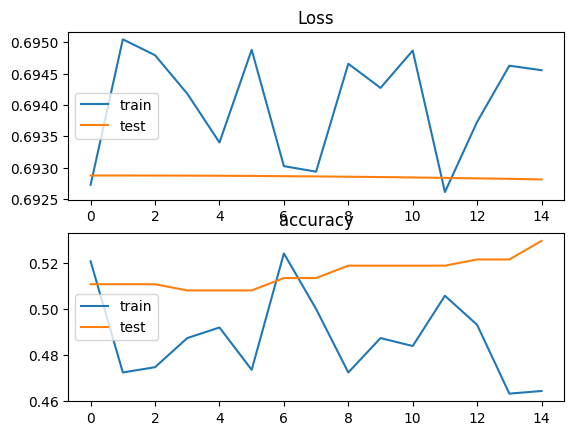

In [ ]:
from matplotlib import pyplot
# plot loss during training
pyplot.subplot(211)


pyplot.title('Loss')
pyplot.plot(history2.history['loss'], label='train')
pyplot.plot(history2.history['val_loss'], label='test')
pyplot.legend()


# plot accuracy during training
pyplot.subplot(212)
pyplot.title('accuracy')
pyplot.plot(history2.history['accuracy'], label='train')
pyplot.plot(history2.history['val_accuracy'], label='test')
pyplot.legend()
pyplot.show()

In [ ]:
def evaluate_model(model, x_test, y_test):
    from sklearn import metrics

    # Predict Test Data
    y_pred = model.predict(x_test)

    # Calculate accuracy, precision, recall, f1-score, and kappa score
    acc = metrics.accuracy_score(y_test, y_pred)
    prec = metrics.precision_score(y_test, y_pred)
    rec = metrics.recall_score(y_test, y_pred)
    f1 = metrics.f1_score(y_test, y_pred)
    kappa = metrics.cohen_kappa_score(y_test, y_pred)

    # Calculate area under curve (AUC)
    y_pred_proba = model.predict_proba(x_test)[::,1]
    fpr, tpr, _ = metrics.roc_curve(y_test, y_pred_proba)
    auc = metrics.roc_auc_score(y_test, y_pred_proba)

    # Display confussion matrix
    cm = metrics.confusion_matrix(y_test, y_pred)

    return {'acc': acc, 'prec': prec, 'rec': rec, 'f1': f1,
            'kappa': kappa,
            'fpr': fpr, 'tpr': tpr, 'auc': auc,
            'cm': cm}

evaluate_model(model, X_test2, Y_test_short2)